SINGAPORE JOB SALARY ANALYSIS PIPELINE
Loading data from database...

=== DATA LOADED ===
Jobs DataFrame: Shape = (1048585, 21)
Categories DataFrame: Shape = (43, 2)
JobCategories DataFrame: Shape = (1767829, 2)
Jobs columns: ['employmentTypes', 'metadata_expiryDate', 'metadata_isPostedOnBehalf', 'metadata_jobPostId', 'metadata_newPostingDate', 'metadata_originalPostingDate', 'metadata_repostCount', 'metadata_totalNumberJobApplication', 'metadata_totalNumberOfView', 'minimumYearsExperience', 'numberOfVacancies', 'occupationId', 'positionLevels', 'postedCompany_name', 'salary_maximum', 'salary_minimum', 'salary_type', 'status_id', 'status_jobStatus', 'title', 'average_salary']

=== CLEANING AND PREPARING DATA ===
Dropped 12 columns

=== CREATING EXPERIENCE LEVEL CATEGORIES ===

=== CREATING INDUSTRY CATEGORIES ===
Created 14 industry categories

=== JOINING DATASETS ===
Final shape: (1048585, 11)

ANALYZING ORIGINAL DATA (BEFORE FILTERING)

=== SALARY ANALYSIS: ORIGINAL DATA ===
Total j

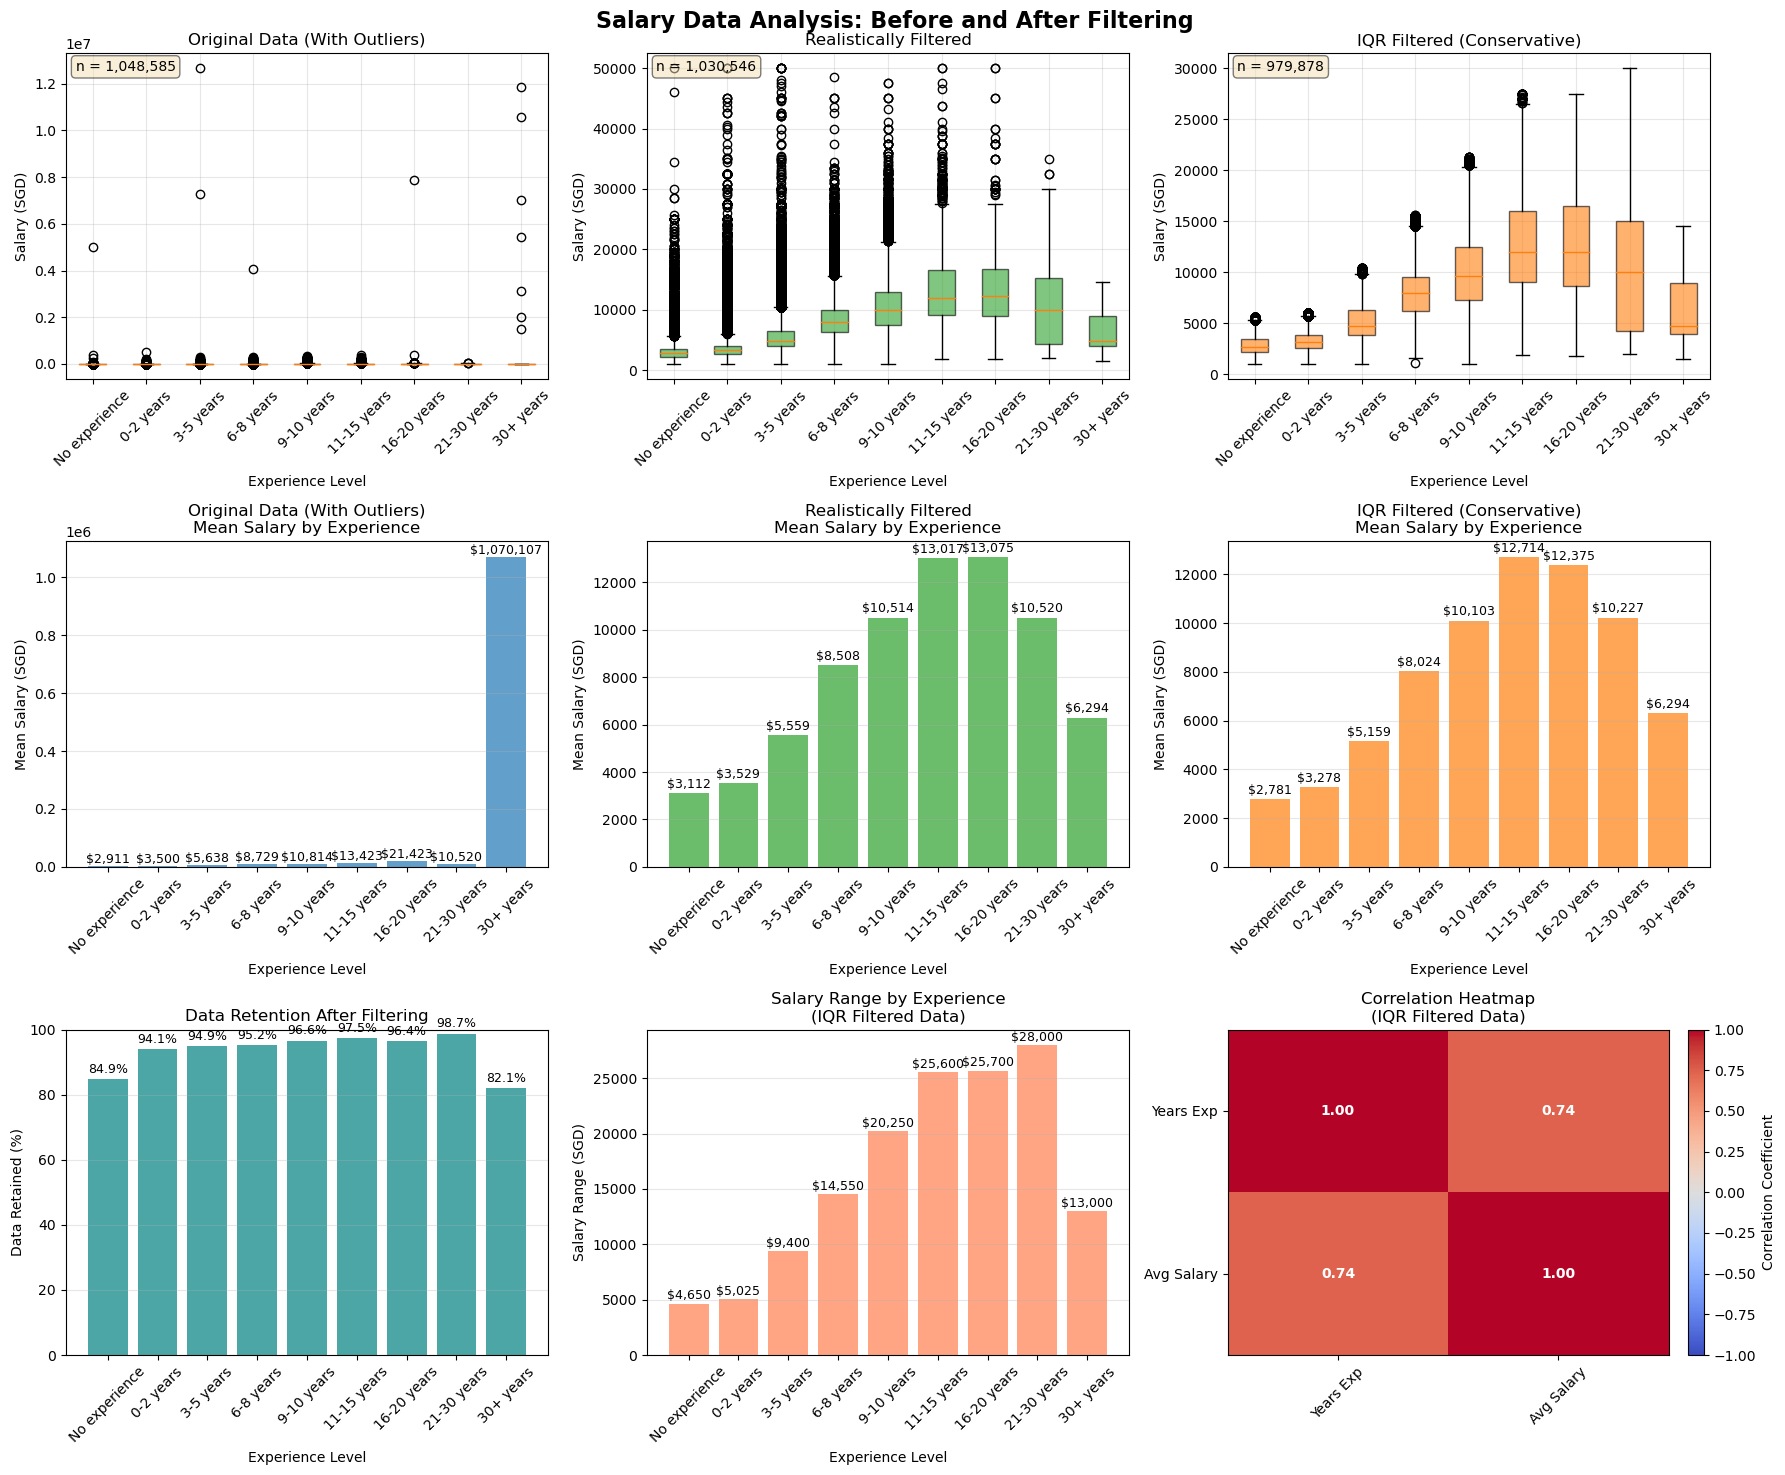

✓ Saved: salary_analysis_comparison.png

=== INDUSTRY SALARY ANALYSIS ===

Top 10 Industries by Average Salary (min. 10 jobs):
                                   count  mean_salary  median_salary  min_salary  max_salary  std_salary
Industry_Category                                                                                       
Engineering & Technical           189442  5568.180176         5000.0      1000.0     27500.0     2757.58
Management & HR                    34706  4832.729980         4000.0      1000.0     27500.0     2721.86
Construction & Real Estate         76711  4642.629883         4050.0      1000.0     30000.0     2008.92
Research & Development              8195  4580.129883         4250.0      1000.0     24000.0     2445.61
Creative & Design                  23491  4523.359863         4000.0      1000.0     25500.0     1998.31
Business & Professional Services  245334  4371.390137         3500.0      1000.0     27500.0     2742.15
Other / Miscellaneous            

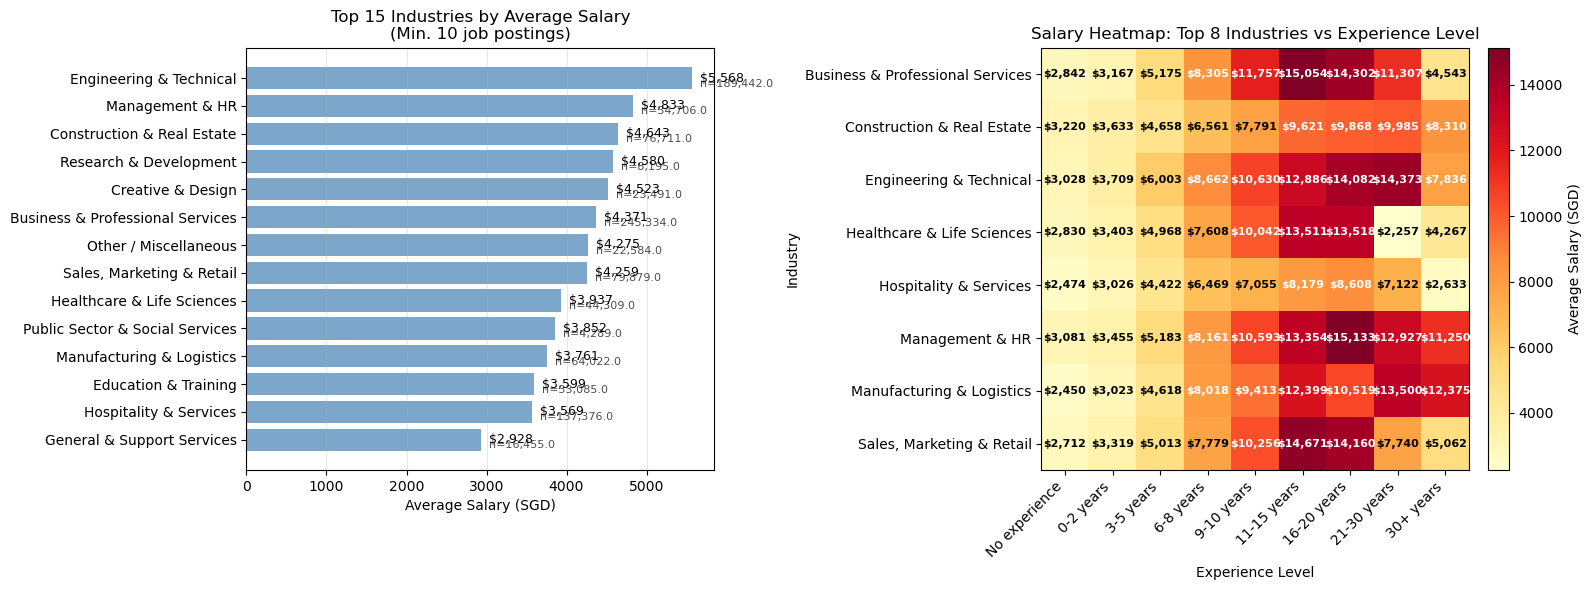

✓ Saved: industry_salary_analysis.png

=== INDUSTRY INSIGHTS ===
Highest paying industry: Engineering & Technical ($5,568.18)
Lowest paying industry: General & Support Services ($2,927.52)
Industry count (min. 10 jobs): 14
Industries with >1000 jobs: 14

=== Saving iqr_cleaned.csv ===

=== OPTIMIZING DATAFRAME ===
Saved 979,878 rows, 8 columns
File size: 126.78 MB

ANALYSIS COMPLETE!

Generated files:
  1. iqr_cleaned.csv - Cleaned dataset for modeling
  2. salary_analysis_comparison.png - Comparative visualizations
  3. industry_salary_analysis.png - Industry salary analysis


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import duckdb
import os

# ============================================================================
# LOAD DATA
# ============================================================================
def load_data(db_path):
    """
    Load data from DuckDB database.
    
    Args:
        db_path: Path to the DuckDB database file
        
    Returns:
        Tuple of (jobs_df, categories_df, jobcategories_df)
    """
    print("Loading data from database...")
    
    # Connect to the database using DuckDB
    conn = duckdb.connect(db_path)
    
    # Load each table
    jobs_df = conn.execute("SELECT * FROM jobs").fetchdf()
    categories_df = conn.execute("SELECT * FROM categories").fetchdf()
    jobcategories_df = conn.execute("SELECT * FROM job_categories").fetchdf()
    
    # Close the connection
    conn.close()
    
    print("\n=== DATA LOADED ===")
    print(f"Jobs DataFrame: Shape = {jobs_df.shape}")
    print(f"Categories DataFrame: Shape = {categories_df.shape}")
    print(f"JobCategories DataFrame: Shape = {jobcategories_df.shape}")
    print(f"Jobs columns: {list(jobs_df.columns)}")
    
    return jobs_df, categories_df, jobcategories_df

# ============================================================================
# CLEANING AND PREPARING DATA
# ============================================================================
def clean_and_prepare_data(jobs_df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean and prepare the jobs dataframe.
    """
    print("\n=== CLEANING AND PREPARING DATA ===")
    
    filtered_jobs = jobs_df.copy()
    
    # Drop redundant columns that exist in the data
    columns_to_drop = [
        'occupationId', 'status_id', 'salary_type', 
        'salary_maximum', 'salary_minimum', 
        'employmentTypes', 'metadata_expiryDate', 
        'metadata_isPostedOnBehalf', 'metadata_newPostingDate', 
        'metadata_originalPostingDate', 'metadata_repostCount',
        'positionLevels'  # Added this column
    ]
    
    existing_columns_to_drop = [col for col in columns_to_drop if col in filtered_jobs.columns]
    if existing_columns_to_drop:
        filtered_jobs = filtered_jobs.drop(columns=existing_columns_to_drop)
        print(f"Dropped {len(existing_columns_to_drop)} columns")
    
    # Convert numeric columns
    if 'minimumYearsExperience' in filtered_jobs.columns:
        filtered_jobs['minimumYearsExperience'] = pd.to_numeric(filtered_jobs['minimumYearsExperience'], errors='coerce')
    
    if 'average_salary' in filtered_jobs.columns:
        filtered_jobs['average_salary'] = pd.to_numeric(filtered_jobs['average_salary'], errors='coerce')
    
    return filtered_jobs


# ============================================================================
# CREATE EXPERIENCE LEVELS
# ============================================================================
def create_experience_levels(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create experience level categories from minimumYearsExperience.
    """
    print("\n=== CREATING EXPERIENCE LEVEL CATEGORIES ===")
    
    if 'minimumYearsExperience' not in df.columns:
        df['experience_level'] = 'Unknown'
        return df
    
    # Define experience levels
    bins = [-1, 0, 2, 5, 8, 10, 15, 20, 30, np.inf]
    labels = [
        'No experience',
        '0-2 years',
        '3-5 years',
        '6-8 years',
        '9-10 years',
        '11-15 years',
        '16-20 years',
        '21-30 years',
        '30+ years'
    ]
    
    df['experience_level'] = pd.cut(df['minimumYearsExperience'], bins=bins, labels=labels, right=True)
    df['experience_level'] = df['experience_level'].cat.add_categories(['Unknown']).fillna('Unknown')
    
    return df


# ============================================================================
# CREATE INDUSTRY CATEGORIES
# ============================================================================
def create_industry_categories(categories_df: pd.DataFrame) -> pd.DataFrame:
    """
    Create broader industry categories from detailed job categories.
    Categories DataFrame has: ['category_id', 'category_name']
    """
    print("\n=== CREATING INDUSTRY CATEGORIES ===")
    
    # Industry mapping (keep as is, it's fine)
    industry_mapping = {
        'Accounting / Auditing / Taxation': 'Business & Professional Services',
        'Admin / Secretarial': 'Business & Professional Services',
        'Banking and Finance': 'Business & Professional Services',
        'Consulting': 'Business & Professional Services',
        'Insurance': 'Business & Professional Services',
        'Legal': 'Business & Professional Services',
        'Professional Services': 'Business & Professional Services',
        'Risk Management': 'Business & Professional Services',
        'Engineering': 'Engineering & Technical',
        'Information Technology': 'Engineering & Technical',
        'Precision Engineering': 'Engineering & Technical',
        'Repair and Maintenance': 'Engineering & Technical',
        'Telecommunications': 'Engineering & Technical',
        'Advertising / Media': 'Sales, Marketing & Retail',
        'Events / Promotions': 'Sales, Marketing & Retail',
        'Marketing / Public Relations': 'Sales, Marketing & Retail',
        'Sales / Retail': 'Sales, Marketing & Retail',
        'Wholesale Trade': 'Sales, Marketing & Retail',
        'Healthcare / Pharmaceutical': 'Healthcare & Life Sciences',
        'Medical / Therapy Services': 'Healthcare & Life Sciences',
        'Environment / Health': 'Healthcare & Life Sciences',
        'Customer Service': 'Hospitality & Services',
        'F&B': 'Hospitality & Services',
        'Hospitality': 'Hospitality & Services',
        'Personal Care / Beauty': 'Hospitality & Services',
        'Travel / Tourism': 'Hospitality & Services',
        'Architecture / Interior Design': 'Creative & Design',
        'Design': 'Creative & Design',
        'Entertainment': 'Creative & Design',
        'Logistics / Supply Chain': 'Manufacturing & Logistics',
        'Manufacturing': 'Manufacturing & Logistics',
        'Purchasing / Merchandising': 'Manufacturing & Logistics',
        'Building and Construction': 'Construction & Real Estate',
        'Real Estate / Property Management': 'Construction & Real Estate',
        'General Management': 'Management & HR',
        'Human Resources': 'Management & HR',
        'Education and Training': 'Education & Training',
        'Sciences / Laboratory / R&D': 'Research & Development',
        'Public / Civil Service': 'Public Sector & Social Services',
        'Social Services': 'Public Sector & Social Services',
        'General Work': 'General & Support Services',
        'Security and Investigation': 'General & Support Services',
        'Others': 'Other / Miscellaneous'
    }
    
    # Apply mapping to category_name column
    categories_df['Industry_Category'] = categories_df['category_name'].map(industry_mapping)
    categories_df['Industry_Category'] = categories_df['Industry_Category'].fillna('Other / Miscellaneous')
    
    print(f"Created {categories_df['Industry_Category'].nunique()} industry categories")
    
    return categories_df


# ============================================================================
# JOIN DATASETS
# ============================================================================
def join_datasets(jobs_df: pd.DataFrame, 
                  categories_df: pd.DataFrame, 
                  jobcategories_df: pd.DataFrame) -> pd.DataFrame:
    """
    Join all three datasets.
    - jobs_df has 'metadata_jobPostId' as job ID
    - jobcategories_df has 'job_id' and 'category_id'
    - categories_df has 'category_id' and 'Industry_Category'
    """
    print("\n=== JOINING DATASETS ===")
    
    # Rename job_id column in jobcategories_df to match jobs_df
    jobcategories_df = jobcategories_df.rename(columns={'job_id': 'metadata_jobPostId'})
    
    # Merge jobcategories with categories to get industry for each job-category pair
    job_with_industry = pd.merge(
        jobcategories_df,
        categories_df[['category_id', 'Industry_Category']],
        on='category_id',
        how='left'
    )
    
    # For jobs with multiple categories, take the first industry
    job_industry = job_with_industry.groupby('metadata_jobPostId').first().reset_index()
    
    # Merge with jobs dataframe
    final_df = pd.merge(
        jobs_df,
        job_industry[['metadata_jobPostId', 'Industry_Category']],
        on='metadata_jobPostId',
        how='left'
    )
    
    # Fill missing industry categories
    final_df['Industry_Category'] = final_df['Industry_Category'].fillna('Unknown')
    
    print(f"Final shape: {final_df.shape}")
    
    return final_df


# ============================================================================
# APPLY REALISTIC SALARY FILTERS
# ============================================================================
def apply_realistic_salary_filters(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply realistic salary filters based on Singapore market.
    """
    print("\n=== APPLYING REALISTIC SALARY FILTERS ===")
    
    if 'average_salary' not in df.columns:
        return df
    
    filtered_df = df.copy()
    
    # Basic salary sanity checks
    filtered_df = filtered_df[filtered_df['average_salary'] >= 1000]
    filtered_df = filtered_df[filtered_df['average_salary'] <= 50000]
    
    print(f"After salary filters: {filtered_df.shape}")
    
    return filtered_df


# ============================================================================
# APPLY IQR OUTLIER FILTER
# ============================================================================
def apply_iqr_outlier_filter(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove salary outliers using IQR method by experience level.
    """
    print("\n=== APPLYING IQR OUTLIER FILTER ===")
    
    if 'average_salary' not in df.columns or 'experience_level' not in df.columns:
        return df
    
    filtered_dfs = []
    
    for exp_level in df['experience_level'].unique():
        level_data = df[df['experience_level'] == exp_level]
        
        if len(level_data) < 10:
            filtered_dfs.append(level_data)
            continue
        
        # Calculate IQR
        Q1 = level_data['average_salary'].quantile(0.25)
        Q3 = level_data['average_salary'].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = max(Q1 - 1.5 * IQR, 1000)
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter outliers
        filtered_level = level_data[
            (level_data['average_salary'] >= lower_bound) & 
            (level_data['average_salary'] <= upper_bound)
        ]
        
        filtered_dfs.append(filtered_level)
    
    result = pd.concat(filtered_dfs, ignore_index=True)
    print(f"After IQR filter: {result.shape}")
    
    return result


# ============================================================================
# ANALYZE SALARY DISTRIBUTION
# ============================================================================
def analyze_salary_distribution(df: pd.DataFrame, title: str = "Data") -> pd.DataFrame:
    """
    Generate salary summary statistics.
    """
    print(f"\n=== SALARY ANALYSIS: {title} ===")
    
    if 'average_salary' not in df.columns:
        return pd.DataFrame()
    
    # Overall statistics
    print(f"Total jobs: {len(df):,}")
    print(f"Mean salary: ${df['average_salary'].mean():,.2f}")
    print(f"Median salary: ${df['average_salary'].median():,.2f}")
    print(f"Salary range: ${df['average_salary'].min():,.0f} - ${df['average_salary'].max():,.0f}")
    
    # By experience level if available
    if 'experience_level' in df.columns:
        summary = df.groupby('experience_level')['average_salary'].agg(['count', 'mean', 'median', 'std']).round(2)
        print("\nBy Experience Level:")
        print(summary)
        return summary
    
    return pd.DataFrame()


# ============================================================================
# OPTIMIZE DATAFRAME
# ============================================================================
def optimize_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Optimize dataframe memory usage.
    """
    print("\n=== OPTIMIZING DATAFRAME ===")
    
    optimized_df = df.copy()
    
    # Downcast numeric columns
    for col in ['average_salary', 'minimumYearsExperience']:
        if col in optimized_df.columns:
            optimized_df[col] = pd.to_numeric(optimized_df[col], downcast='float')
    
    # Convert categorical columns
    for col in ['experience_level', 'Industry_Category']:
        if col in optimized_df.columns:
            optimized_df[col] = optimized_df[col].astype('category')
    
    # Convert string columns
    for col in ['metadata_jobPostId', 'title', 'postedCompany_name', 'status_jobStatus']:
        if col in optimized_df.columns:
            optimized_df[col] = optimized_df[col].astype('string')
    
    return optimized_df


# ============================================================================
# SAVE DATASETS
# ============================================================================
def save_datasets(filtered_df: pd.DataFrame) -> None:
    """
    Save the cleaned dataset.
    """
    import os
    
    filename = "iqr_cleaned.csv"
    print("\n=== Saving iqr_cleaned.csv ===")
    
    # Columns to keep - only if they exist
    columns_to_keep = [
        'metadata_jobPostId',
        'title',
        'postedCompany_name',
        'minimumYearsExperience',
        'experience_level',
        'average_salary',
        'Industry_Category',
        'status_jobStatus'
    ]
    
    existing_columns = [col for col in columns_to_keep if col in filtered_df.columns]
    reduced_df = filtered_df[existing_columns].copy()
    
    # Optimize and save
    optimized_df = optimize_dataframe(reduced_df)
    optimized_df.to_csv(filename, index=False)
    
    print(f"Saved {len(optimized_df):,} rows, {len(optimized_df.columns)} columns")
    
    if os.path.exists(filename):
        size_mb = os.path.getsize(filename) / (1024 * 1024)
        print(f"File size: {size_mb:.2f} MB")

# ============================================================================
# VISUALIZATIONS
# ============================================================================
def create_visualizations(original_df: pd.DataFrame, 
                         filtered_df: pd.DataFrame, 
                         iqr_df: pd.DataFrame) -> None:
    """
    Create visualizations comparing original, filtered, and IQR-cleaned data.
    
    Args:
        original_df: Original dataframe (with outliers)
        filtered_df: Realistically filtered dataframe
        iqr_df: IQR-filtered dataframe
    """
    print("\n=== CREATING VISUALIZATIONS ===")
    
    # Check if we have the required columns
    if 'experience_level' not in original_df.columns or 'average_salary' not in original_df.columns:
        print("Warning: Required columns not found for visualizations")
        return
    
    # Create figure with multiple subplots
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle('Salary Data Analysis: Before and After Filtering', fontsize=16, fontweight='bold')
    
    datasets = [
        (original_df, 'Original Data (With Outliers)', 'tab:blue'),
        (filtered_df, 'Realistically Filtered', 'tab:green'),
        (iqr_df, 'IQR Filtered (Conservative)', 'tab:orange')
    ]
    
    # Define experience levels order - UPDATED to match create_experience_levels()
    exp_levels = [
        'No experience',
        '0-2 years',
        '3-5 years',
        '6-8 years',
        '9-10 years',
        '11-15 years',
        '16-20 years',
        '21-30 years',
        '30+ years',
        'Unknown'
    ]
    
    # Row 1: Box plots
    for i, (df, title, color) in enumerate(datasets):
        ax = axes[0, i]
        
        # Prepare data for boxplot
        box_data = []
        valid_levels = []
        for level in exp_levels:
            if level in df['experience_level'].unique():
                level_data = df[df['experience_level'] == level]['average_salary'].dropna()
                if len(level_data) > 0:
                    box_data.append(level_data)
                    valid_levels.append(level)
        
        if box_data:
            bp = ax.boxplot(box_data, labels=valid_levels, patch_artist=True)
            # Set box colors
            for box in bp['boxes']:
                box.set_facecolor(color)
                box.set_alpha(0.6)
            
            ax.set_title(title)
            ax.set_xlabel('Experience Level')
            ax.set_ylabel('Salary (SGD)')
            ax.tick_params(axis='x', rotation=45)
            ax.grid(True, alpha=0.3)
            
            # Add sample size annotation
            total_samples = sum(len(data) for data in box_data)
            ax.text(0.02, 0.98, f'n = {total_samples:,}', 
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Row 2: Mean salary by experience level
    for i, (df, title, color) in enumerate(datasets):
        ax = axes[1, i]
        
        # Calculate mean salary by experience level
        mean_salaries = []
        plot_levels = []
        for level in exp_levels:
            if level in df['experience_level'].unique():
                mean_val = df[df['experience_level'] == level]['average_salary'].mean()
                if not pd.isna(mean_val):
                    mean_salaries.append(mean_val)
                    plot_levels.append(level)
        
        if mean_salaries:
            # Plot
            bars = ax.bar(range(len(plot_levels)), mean_salaries, color=color, alpha=0.7)
            ax.set_title(f'{title}\nMean Salary by Experience')
            ax.set_xlabel('Experience Level')
            ax.set_ylabel('Mean Salary (SGD)')
            ax.set_xticks(range(len(plot_levels)))
            ax.set_xticklabels(plot_levels, rotation=45)
            ax.grid(True, alpha=0.3, axis='y')
            
            # Add value labels
            for bar, salary in zip(bars, mean_salaries):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 100,
                       f'${salary:,.0f}', ha='center', va='bottom', fontsize=9)
    
    # Row 3: Data retention and additional metrics
    # Subplot 1: Data retention rate
    ax1 = axes[2, 0]
    retention_rates = []
    plot_levels = []
    
    for level in exp_levels:
        if level in original_df['experience_level'].unique():
            original_count = len(original_df[original_df['experience_level'] == level])
            final_count = len(iqr_df[iqr_df['experience_level'] == level])
            if original_count > 0:
                retention = (final_count / original_count) * 100
                retention_rates.append(retention)
                plot_levels.append(level)
    
    if retention_rates:
        bars = ax1.bar(range(len(plot_levels)), retention_rates, color='teal', alpha=0.7)
        ax1.set_title('Data Retention After Filtering')
        ax1.set_xlabel('Experience Level')
        ax1.set_ylabel('Data Retained (%)')
        ax1.set_xticks(range(len(plot_levels)))
        ax1.set_xticklabels(plot_levels, rotation=45)
        ax1.grid(True, alpha=0.3, axis='y')
        ax1.set_ylim(0, 100)
        
        # Add percentage labels
        for bar, rate in zip(bars, retention_rates):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{rate:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # Subplot 2: Salary range by experience (IQR filtered data)
    ax2 = axes[2, 1]
    salary_ranges = []
    plot_levels = []
    
    for level in exp_levels:
        if level in iqr_df['experience_level'].unique():
            level_data = iqr_df[iqr_df['experience_level'] == level]['average_salary']
            if len(level_data) > 0:
                salary_range = level_data.max() - level_data.min()
                salary_ranges.append(salary_range)
                plot_levels.append(level)
            else:
                salary_ranges.append(0)
                plot_levels.append(level)
    
    if salary_ranges:
        bars = ax2.bar(range(len(plot_levels)), salary_ranges, color='coral', alpha=0.7)
        ax2.set_title('Salary Range by Experience\n(IQR Filtered Data)')
        ax2.set_xlabel('Experience Level')
        ax2.set_ylabel('Salary Range (SGD)')
        ax2.set_xticks(range(len(plot_levels)))
        ax2.set_xticklabels(plot_levels, rotation=45)
        ax2.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar, salary_range in zip(bars, salary_ranges):
            if salary_range > 0:
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height + 100,
                       f'${salary_range:,.0f}', ha='center', va='bottom', fontsize=9)
    
    # Subplot 3: Correlation heatmap (IQR filtered data)
    ax3 = axes[2, 2]
    
    # Prepare data for correlation
    if 'minimumYearsExperience' in iqr_df.columns and 'average_salary' in iqr_df.columns:
        # Filter out rows with missing values
        corr_data = iqr_df[['minimumYearsExperience', 'average_salary']].dropna()
        if len(corr_data) > 0:
            corr_matrix = corr_data.corr()
            
            # Create heatmap
            im = ax3.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
            ax3.set_title('Correlation Heatmap\n(IQR Filtered Data)')
            
            # Set ticks and labels
            tick_labels = ['Years Exp', 'Avg Salary']
            ax3.set_xticks(range(len(tick_labels)))
            ax3.set_yticks(range(len(tick_labels)))
            ax3.set_xticklabels(tick_labels, rotation=45)
            ax3.set_yticklabels(tick_labels)
            
            # Add correlation values
            for i in range(len(tick_labels)):
                for j in range(len(tick_labels)):
                    value = corr_matrix.iloc[i, j]
                    color = 'white' if abs(value) > 0.5 else 'black'
                    ax3.text(j, i, f'{value:.2f}', ha='center', va='center', color=color, fontweight='bold')
            
            # Add colorbar
            cbar = plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)
            cbar.set_label('Correlation Coefficient')
        else:
            ax3.text(0.5, 0.5, 'Insufficient data for correlation', 
                    ha='center', va='center', transform=ax3.transAxes)
            ax3.set_title('Correlation Heatmap\n(Data Unavailable)')
    else:
        ax3.text(0.5, 0.5, 'Insufficient data for correlation', 
                ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Correlation Heatmap\n(Data Unavailable)')
    
    plt.tight_layout()
    plt.savefig('salary_analysis_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: salary_analysis_comparison.png")


def industry_salary_analysis(df: pd.DataFrame) -> None:
    """
    Analyze salary by industry category.
    
    Args:
        df: Cleaned dataframe with industry information
    """
    print("\n=== INDUSTRY SALARY ANALYSIS ===")
    
    # Check if we have the required columns
    if 'Industry_Category' not in df.columns or 'average_salary' not in df.columns:
        print("Warning: Required columns not found for industry analysis")
        return
    
    # Top industries by average salary
    industry_salaries = df.groupby('Industry_Category')['average_salary'].agg([
        ('count', 'size'),
        ('mean_salary', 'mean'),
        ('median_salary', 'median'),
        ('min_salary', 'min'),
        ('max_salary', 'max'),
        ('std_salary', 'std')
    ]).round(2)
    
    # Filter to industries with sufficient data (at least 10 jobs)
    industry_salaries = industry_salaries[industry_salaries['count'] >= 10]
    
    # Sort by mean salary
    industry_salaries = industry_salaries.sort_values('mean_salary', ascending=False)
    
    print("\nTop 10 Industries by Average Salary (min. 10 jobs):")
    print(industry_salaries.head(10).to_string())
    
    print("\nBottom 10 Industries by Average Salary (min. 10 jobs):")
    print(industry_salaries.tail(10).to_string())
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Top 15 industries by average salary
    top_15 = industry_salaries.head(15)
    if len(top_15) > 0:
        ax1 = axes[0]
        bars1 = ax1.barh(range(len(top_15)), top_15['mean_salary'], color='steelblue', alpha=0.7)
        ax1.set_yticks(range(len(top_15)))
        ax1.set_yticklabels(top_15.index)
        ax1.set_xlabel('Average Salary (SGD)')
        ax1.set_title('Top 15 Industries by Average Salary\n(Min. 10 job postings)')
        ax1.invert_yaxis()  # Highest at top
        ax1.grid(True, alpha=0.3, axis='x')
        
        # Add value labels
        for i, (idx, row) in enumerate(top_15.iterrows()):
            ax1.text(row['mean_salary'] + 100, i, f'${row["mean_salary"]:,.0f}', 
                    va='center', fontsize=9)
            ax1.text(row['mean_salary'] + 100, i + 0.2, f'n={row["count"]:,}', 
                    va='center', fontsize=8, alpha=0.7)
    
    # Plot 2: Industry salary by experience level (heatmap)
    ax2 = axes[1]
    
    # Check if we have experience_level column
    if 'experience_level' in df.columns:
        # Get top 8 industries by count for better readability
        top_8_industries = df['Industry_Category'].value_counts().head(8).index
        
        # Create pivot table
        pivot_data = df[df['Industry_Category'].isin(top_8_industries)]
        
        if len(pivot_data) > 0:
            pivot_table = pivot_data.pivot_table(
                values='average_salary',
                index='Industry_Category',
                columns='experience_level',
                aggfunc='mean'
            )
            
            # Reorder columns by experience - UPDATED to match new bins
            exp_order = [
                'No experience', '0-2 years', '3-5 years', '6-8 years', '9-10 years',
                '11-15 years', '16-20 years', '21-30 years', '30+ years', 'Unknown'
            ]
            pivot_table = pivot_table.reindex(columns=[col for col in exp_order if col in pivot_table.columns])
            
            # Create heatmap
            if not pivot_table.empty:
                im = ax2.imshow(pivot_table.values, cmap='YlOrRd', aspect='auto')
                ax2.set_title('Salary Heatmap: Top 8 Industries vs Experience Level')
                ax2.set_xlabel('Experience Level')
                ax2.set_ylabel('Industry')
                
                # Set ticks
                ax2.set_xticks(range(len(pivot_table.columns)))
                ax2.set_xticklabels(pivot_table.columns, rotation=45, ha='right')
                ax2.set_yticks(range(len(pivot_table.index)))
                ax2.set_yticklabels(pivot_table.index)
                
                # Add colorbar
                cbar = plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
                cbar.set_label('Average Salary (SGD)')
                
                # Add salary annotations
                for i in range(len(pivot_table.index)):
                    for j in range(len(pivot_table.columns)):
                        value = pivot_table.iloc[i, j]
                        if not pd.isna(value):
                            text_color = 'white' if value > pivot_table.values.mean() else 'black'
                            ax2.text(j, i, f'${value:,.0f}', ha='center', va='center', 
                                   color=text_color, fontsize=8, fontweight='bold')
            else:
                ax2.text(0.5, 0.5, 'Insufficient data for heatmap', 
                        ha='center', va='center', transform=ax2.transAxes)
                ax2.set_title('Salary Heatmap\n(Insufficient Data)')
        else:
            ax2.text(0.5, 0.5, 'Insufficient data for heatmap', 
                    ha='center', va='center', transform=ax2.transAxes)
            ax2.set_title('Salary Heatmap\n(Insufficient Data)')
    else:
        ax2.text(0.5, 0.5, 'Experience level data not available', 
                ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Salary Heatmap\n(Data Unavailable)')
    
    plt.tight_layout()
    plt.savefig('industry_salary_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: industry_salary_analysis.png")
    
    # Print industry insights
    if len(industry_salaries) > 0:
        print("\n=== INDUSTRY INSIGHTS ===")
        print(f"Highest paying industry: {industry_salaries.index[0]} (${industry_salaries.iloc[0]['mean_salary']:,.2f})")
        print(f"Lowest paying industry: {industry_salaries.index[-1]} (${industry_salaries.iloc[-1]['mean_salary']:,.2f})")
        print(f"Industry count (min. 10 jobs): {len(industry_salaries)}")
        print(f"Industries with >1000 jobs: {(industry_salaries['count'] > 1000).sum()}")


# ============================================================================
# MAIN FUNCTION
# ============================================================================
def main():
    """Main function to run the complete analysis pipeline."""
    print("=" * 80)
    print("SINGAPORE JOB SALARY ANALYSIS PIPELINE")
    print("=" * 80)
    
    # Database path
    '''
    db_path = input("Enter the .db file path: ").strip()
    if not db_path:
        print("Error: No input file path provided.")
        return
    '''
    db_path = "./data/job_postings.db"
    try:
        # Step 1: Load data
        jobs_df, categories_df, jobcategories_df = load_data(db_path)
        
        # Step 2: Clean and prepare data - DROP UNUSED COLUMNS EARLY
        cleaned_jobs = clean_and_prepare_data(jobs_df)
        
        # Step 3: Create experience levels
        cleaned_jobs = create_experience_levels(cleaned_jobs)
        
        # Step 4: Create industry categories
        categories_df = create_industry_categories(categories_df)
        
        # Step 5: Join all datasets - only bring in necessary columns
        merged_df = join_datasets(cleaned_jobs, categories_df, jobcategories_df)
        
        # Step 6: Analyze original data (before filtering)
        print("\n" + "=" * 80)
        print("ANALYZING ORIGINAL DATA (BEFORE FILTERING)")
        print("=" * 80)
        original_summary = analyze_salary_distribution(merged_df, "ORIGINAL DATA")
        
        # Step 7: Apply realistic salary filters
        realistically_filtered = apply_realistic_salary_filters(merged_df)
        filtered_summary = analyze_salary_distribution(realistically_filtered, "REALISTICALLY FILTERED")
        
        # Step 8: Apply IQR outlier filter
        iqr_filtered = apply_iqr_outlier_filter(realistically_filtered)
        iqr_summary = analyze_salary_distribution(iqr_filtered, "IQR FILTERED")
        
        # Step 9: Create visualizations
        print("\n" + "=" * 80)
        print("GENERATING VISUALIZATIONS")
        print("=" * 80)
        
        create_visualizations(merged_df, realistically_filtered, iqr_filtered)
        industry_salary_analysis(iqr_filtered)
        
        # Step 10: Save the IQR cleaned dataset with reduced columns and optimized data types
        save_datasets(iqr_filtered)
        
        print("\n" + "=" * 80)
        print("ANALYSIS COMPLETE!")
        print("=" * 80)
        print("\nGenerated files:")
        print("  1. iqr_cleaned.csv - Cleaned dataset for modeling")
        print("  2. salary_analysis_comparison.png - Comparative visualizations")
        print("  3. industry_salary_analysis.png - Industry salary analysis")
            
    except FileNotFoundError:
        print(f"\nError: Database file not found at {db_path}")
        print("Please update the db_path variable with the correct path.")
    except Exception as e:
        print(f"\nError during analysis: {str(e)}")
        import traceback
        traceback.print_exc()


if __name__ == "__main__":
    main()
